In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["top_position"] = billboard_hot_100.groupby("artist_song")["position"].transform("min")

## Rank turnover

In [6]:
# number of songs ever seen until time t
def number_of_songs_seen(df, t):
    return len(df[df["first_day_of_the_week"] <= t]["artist_song"].unique())/100

100%|██████████| 3361/3361 [02:39<00:00, 21.12it/s]


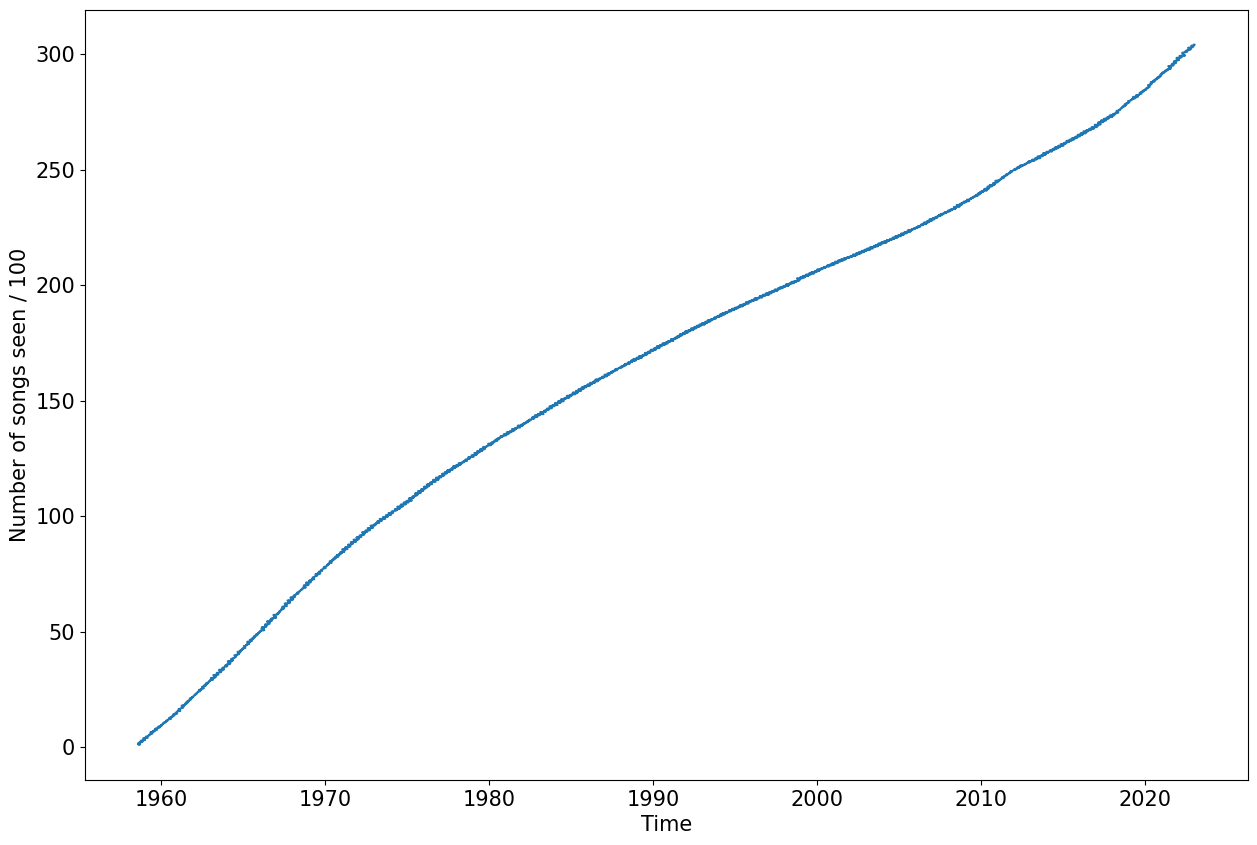

In [7]:
number_of_songs_ever_seen = []
for first_day_of_the_week in tqdm(billboard_hot_100["first_day_of_the_week"].sort_values().unique()):
    number_of_songs_ever_seen.append(number_of_songs_seen(billboard_hot_100, first_day_of_the_week))

plt.figure(figsize=(15, 10))
plt.plot(billboard_hot_100["first_day_of_the_week"].unique(), number_of_songs_ever_seen)
plt.xlabel("Time")
plt.ylabel("Number of songs seen / 100")
plt.show()

## Rank flux

In [8]:
# songs_seen_t = {}
# songs_seen_before_t = {}
# for t in tqdm(billboard_hot_100["first_day_of_the_week"].unique()):
#     songs_seen_t[t] = billboard_hot_100[billboard_hot_100["first_day_of_the_week"] <= t]["artist_song"].unique()
#     songs_seen_before_t[t] = billboard_hot_100[billboard_hot_100["first_day_of_the_week"] < t]["artist_song"].unique()

In [9]:
# probabilities that song enter or leaves the chart at time t
def song_enter_leave_probabilities(df, t):
    songs_previous_week = df[df["first_day_of_the_week"] == (pd.to_datetime(t) - timedelta(weeks=1))]["artist_song"].unique()
    songs_now = df[df["first_day_of_the_week"] == t]["artist_song"].unique()
    songs_entered = list(set(songs_now) - set(songs_previous_week))
    songs_left = list(set(songs_previous_week) - set(songs_now))
    return (len(songs_entered) + len(songs_left))/200

100%|██████████| 3361/3361 [00:11<00:00, 299.25it/s]


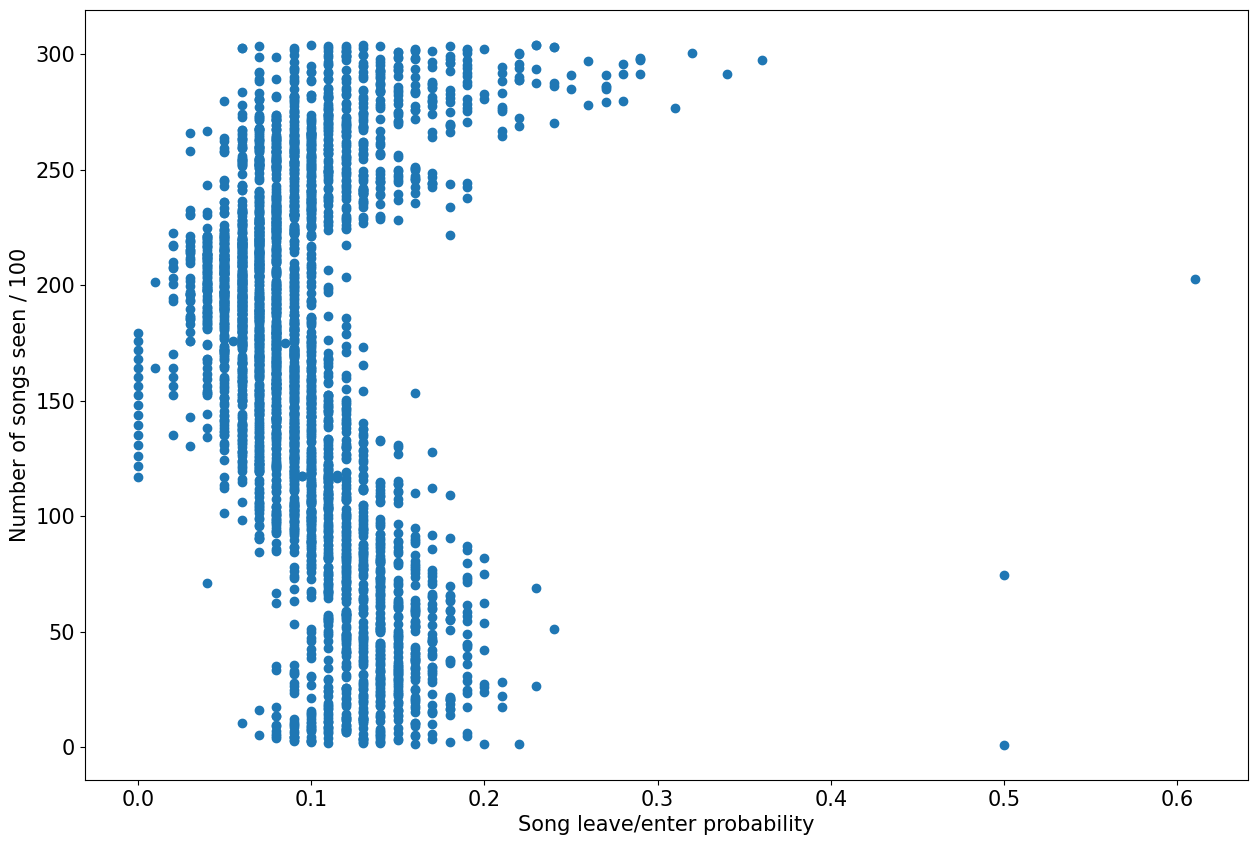

In [10]:
enter_leave_porbabilities = []
for first_day_of_the_week in tqdm(billboard_hot_100["first_day_of_the_week"].sort_values().unique()):
    enter_leave_porbabilities.append(song_enter_leave_probabilities(billboard_hot_100, first_day_of_the_week))

plt.figure(figsize=(15, 10))
plt.scatter(enter_leave_porbabilities, number_of_songs_ever_seen)
plt.xlabel("Song leave/enter probability")
plt.ylabel("Number of songs seen / 100")
# plt.yscale("log")
# plt.xscale("log")
plt.show()

In [11]:
np.corrcoef(number_of_songs_ever_seen, enter_leave_porbabilities)

array([[ 1.        , -0.20740298],
       [-0.20740298,  1.        ]])

## Rank change - Probability that element at position R changes between t-1 and time t 

In [12]:
billboard_hot_100["position_changed"] = billboard_hot_100["position"] != billboard_hot_100["last_week_position"]

In [13]:
# calculate probability that the songs at position R changed positionb between t-1 and t
def position_change_probability(df, R):
    df_position_r = df[df["position"] == R]
    
    number_of_songs_that_changed_position = len(df_position_r[df_position_r["position_changed"] == True])
    # songs_stayed = songs_stayed[:R]
    # songs_entered = songs_entered[:R]
    # songs_left = songs_left[:R]
    return number_of_songs_that_changed_position/df_position_r.shape[0]

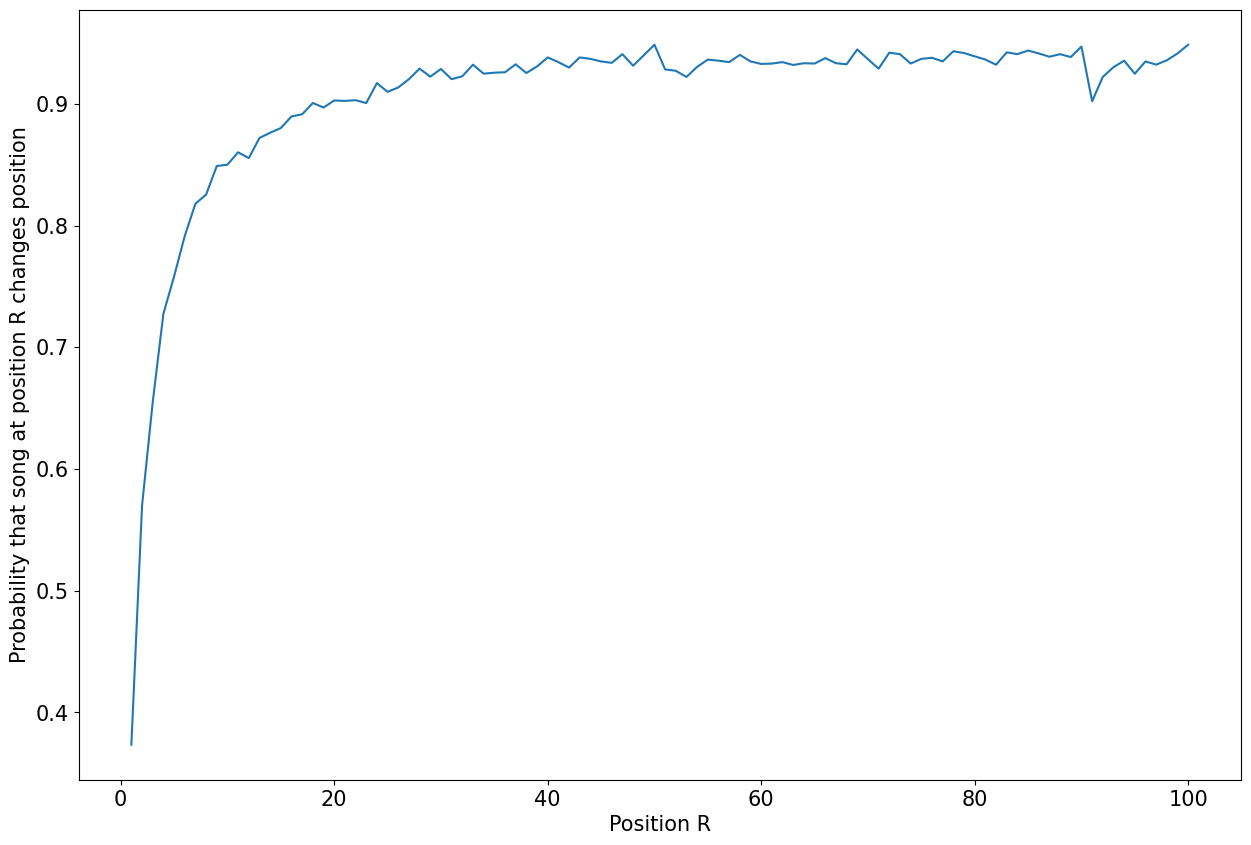

In [14]:
position_change_probabilities = []
for R in range(1, 101):
    position_change_probabilities.append(position_change_probability(billboard_hot_100, R))

plt.figure(figsize=(15, 10))
plt.plot(range(1, 101), position_change_probabilities)
plt.xlabel("Position R")
plt.ylabel("Probability that song at position R changes position")
plt.show()

## Artist popularity vs. position

In [38]:
#calculate artist popularity
def artist_popularity(df_artist):
    return (101 - df_artist["position"]).sum()
    # number_of_songs_in_top_10 = len(df_artist[df_artist["top_position"] <= 10])
    # number_of_all_unique_songs = len(df_artist["artist_song"].unique())
    # avg_max_weeks_on_chart = df_artist.groupby("artist_song")["weeks_on_chart"].max().mean()
    # return number_of_songs_in_top_10/100 + number_of_all_unique_songs/500 + avg_max_weeks_on_chart/1000

In [33]:
test=billboard_hot_100.groupby("artist")['song_name'].nunique()
test[test == 183]

artist
Glee Cast    183
Name: song_name, dtype: int64

In [39]:
df_artist_populairty = billboard_hot_100.groupby("artist").apply(lambda x: artist_popularity(x)).reset_index(name="artist_popularity")
billboard_hot_100["artist_popularity"] = billboard_hot_100["artist"].map(df_artist_populairty.set_index("artist")["artist_popularity"])

In [24]:
def normalize(df, column):
    return (df[column] - df[column].min())/(df[column].max() - df[column].min())

In [40]:
# noramlize artist popularity
billboard_hot_100["artist_popularity"] = normalize(billboard_hot_100, "artist_popularity")

In [27]:
billboard_hot_100.groupby("artist")["artist_popularity"].max().sort_values(ascending=False).head(10)

artist
Taylor Swift       1.000000
Madonna            0.816568
Elton John         0.789638
Mariah Carey       0.698071
Drake              0.673233
Stevie Wonder      0.604398
The Beatles        0.603217
Michael Jackson    0.569824
Rihanna            0.551591
Rod Stewart        0.538880
Name: artist_popularity, dtype: float64

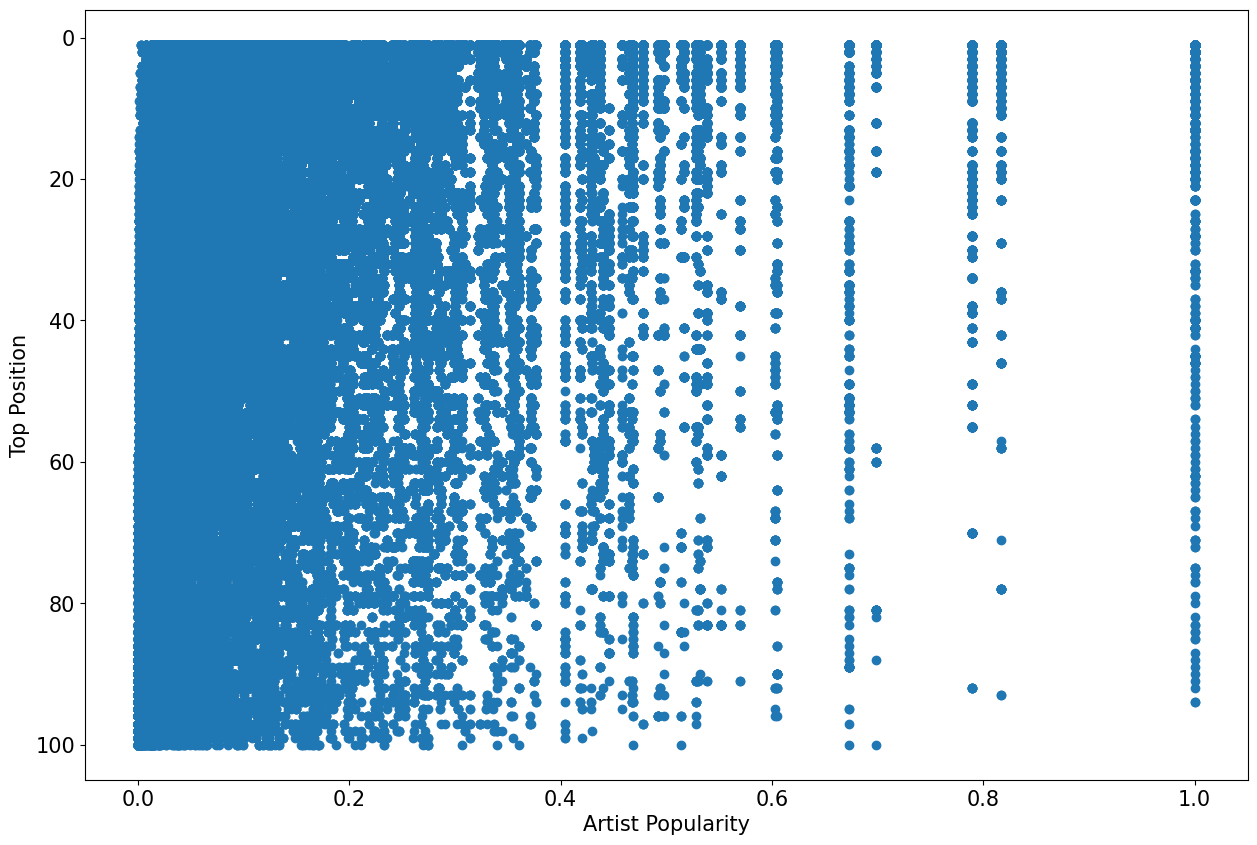

In [28]:
plt.figure(figsize=(15, 10))

plt.scatter(billboard_hot_100["artist_popularity"], billboard_hot_100["top_position"])
plt.xlabel("Artist Popularity")
plt.ylabel("Top Position")

plt.gca().invert_yaxis()
plt.show()

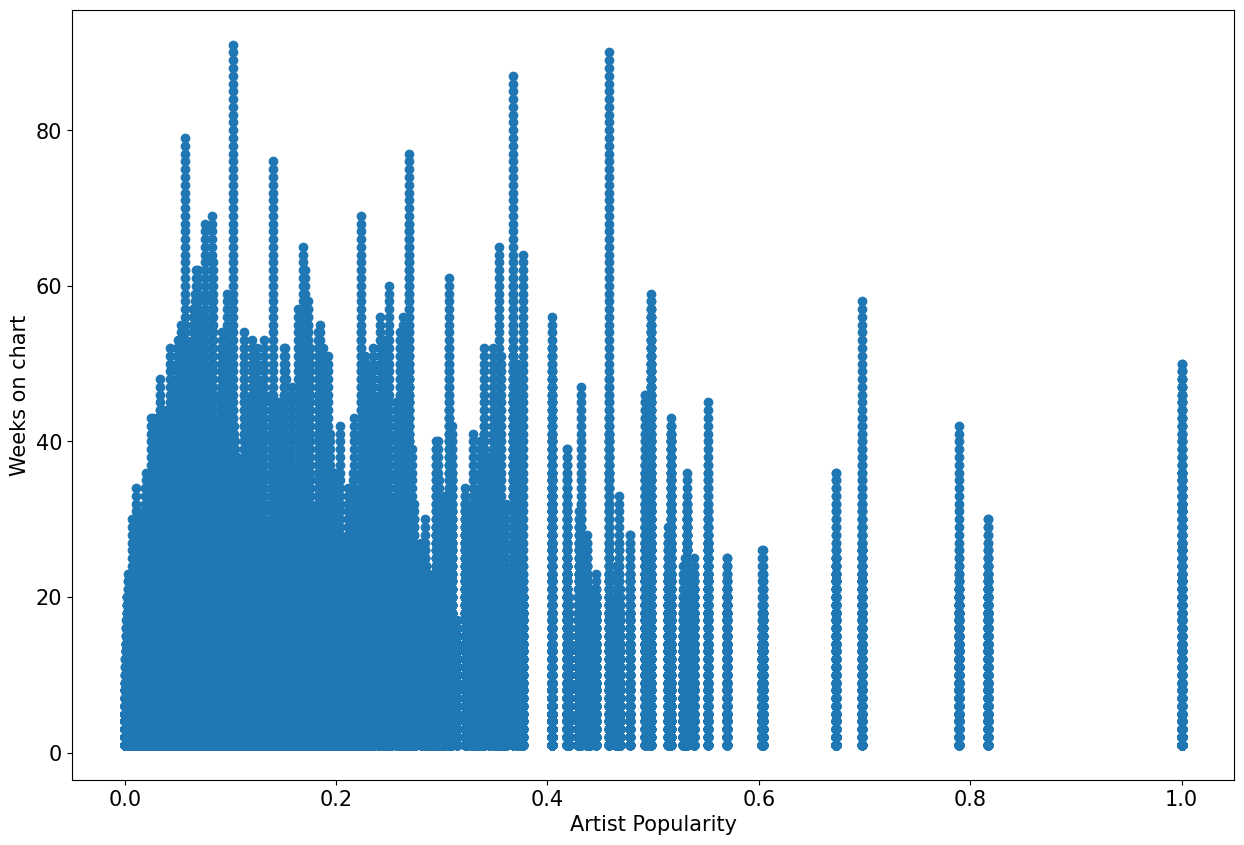

In [29]:
plt.figure(figsize=(15, 10))

plt.scatter(billboard_hot_100["artist_popularity"], billboard_hot_100["weeks_on_chart"])
plt.xlabel("Artist Popularity")
plt.ylabel("Weeks on chart")

plt.show()

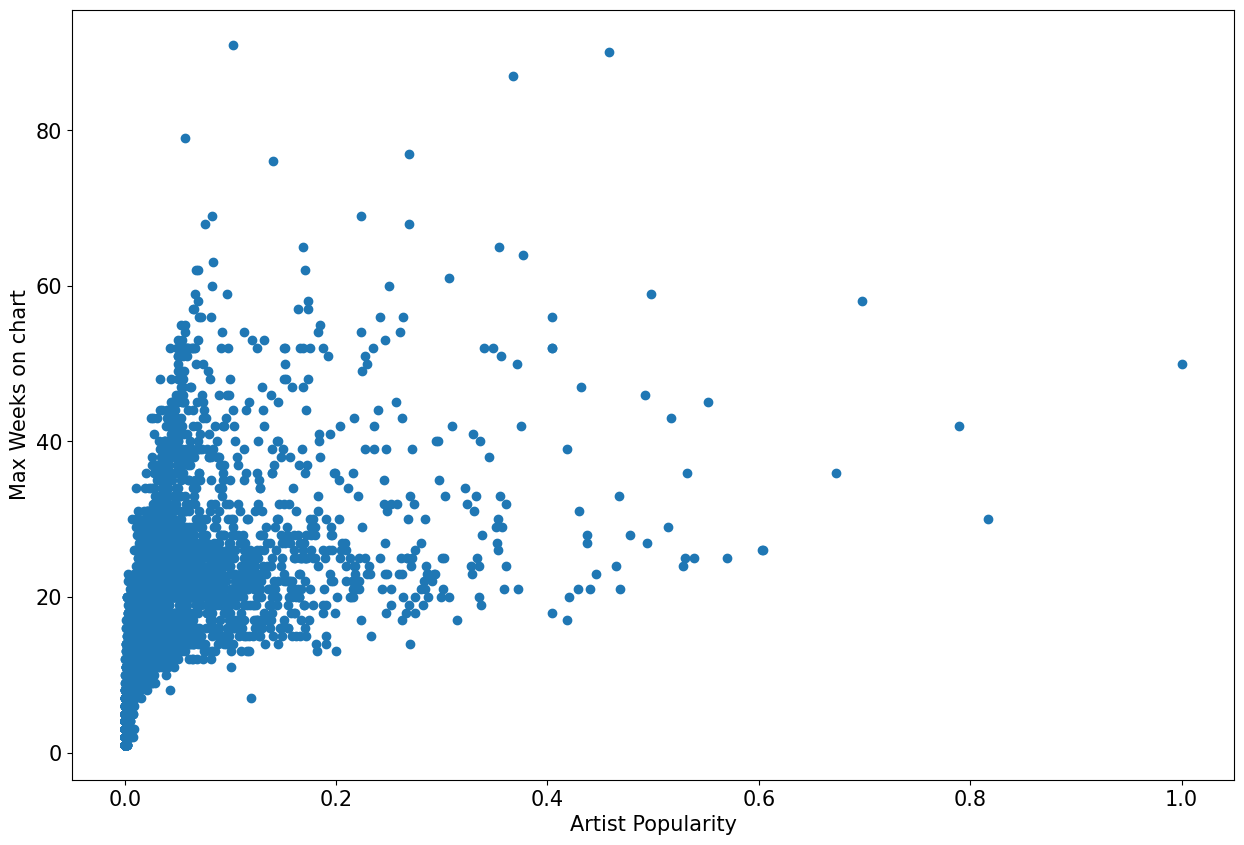

In [30]:
plt.figure(figsize=(15, 10))

plt.scatter(billboard_hot_100.groupby("artist")["artist_popularity"].first(), billboard_hot_100.groupby("artist")["weeks_on_chart"].max())

plt.xlabel("Artist Popularity")
plt.ylabel("Max Weeks on chart")

plt.show()

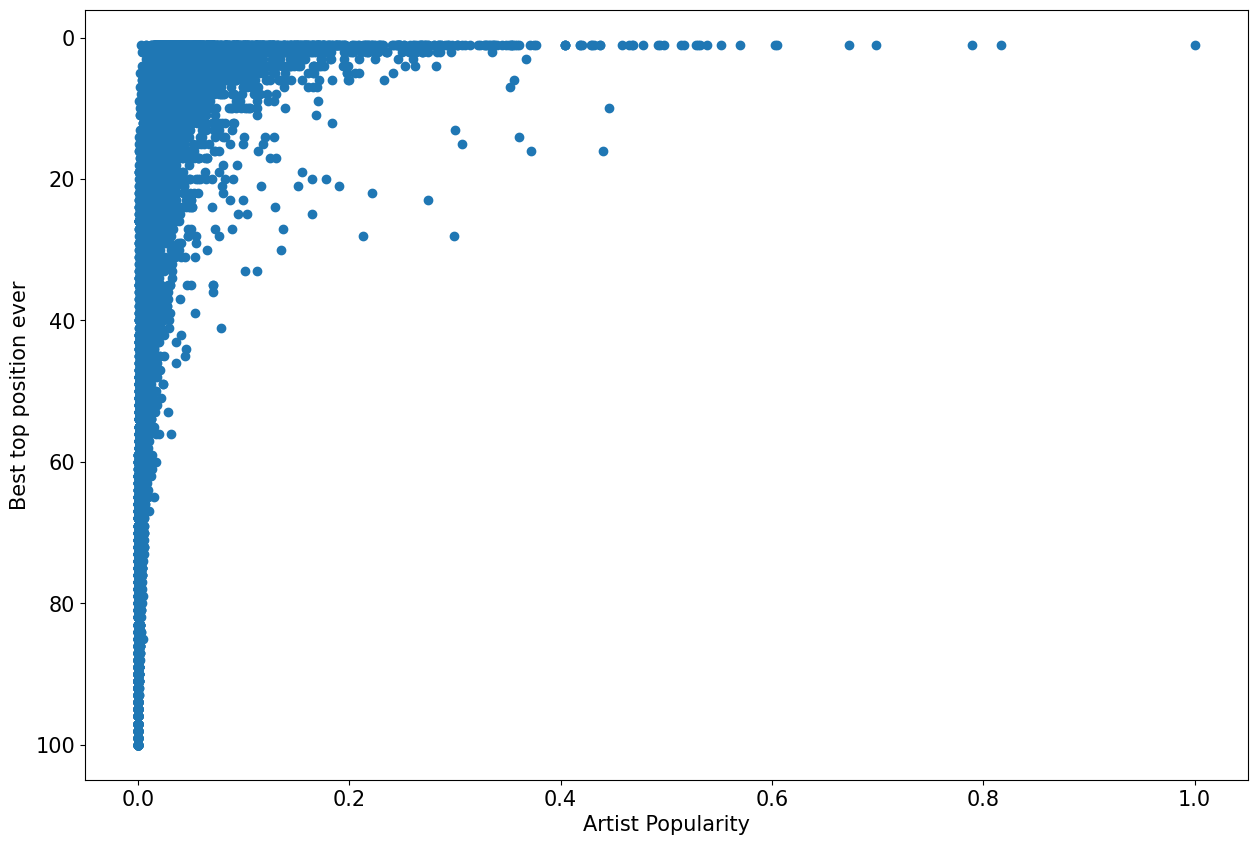

In [31]:
plt.figure(figsize=(15, 10))

plt.scatter(billboard_hot_100.groupby("artist")["artist_popularity"].first(), billboard_hot_100.groupby("artist")["top_position"].min())

plt.xlabel("Artist Popularity")
plt.ylabel("Best top position ever")

plt.gca().invert_yaxis()
plt.show()

## How many artists get to be in top 10 in each year

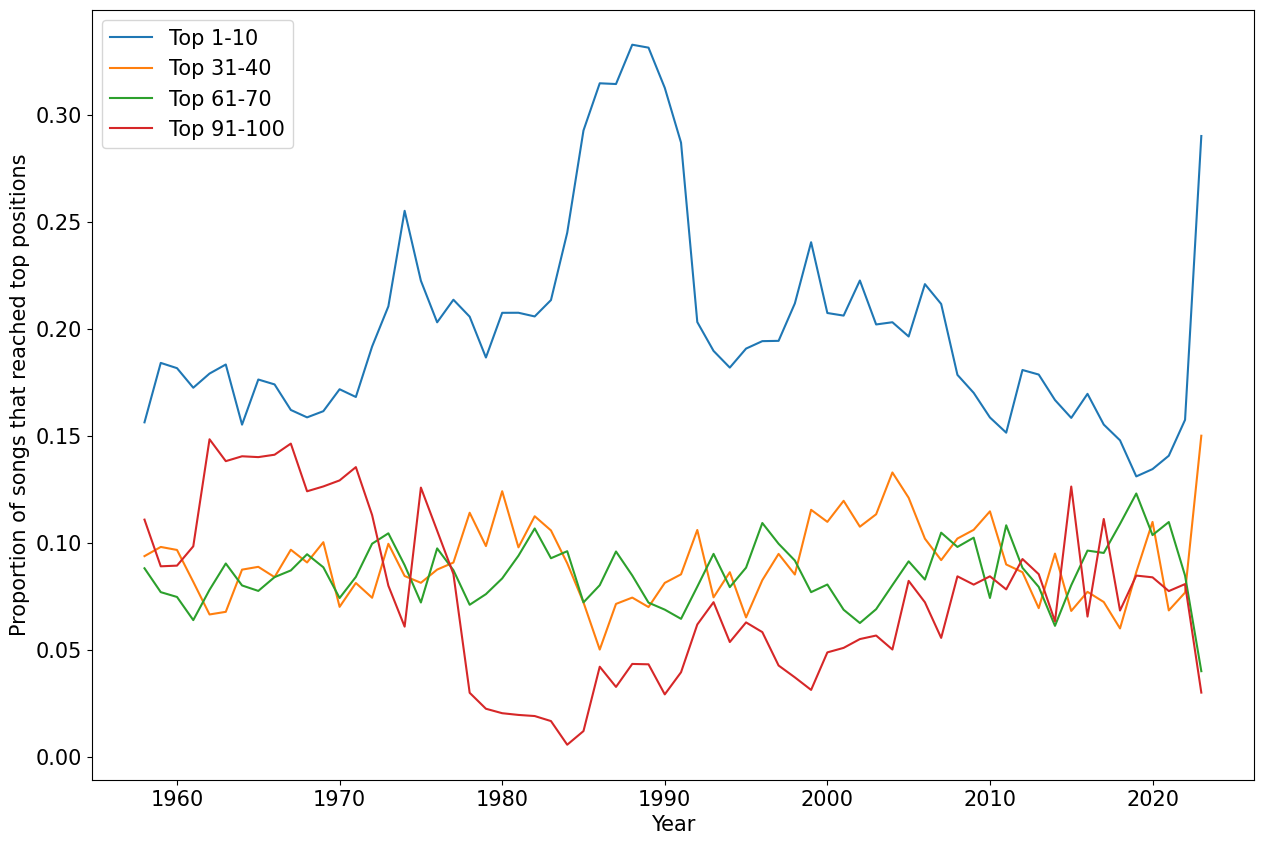

In [57]:
plt.figure(figsize=(15, 10))

for i in range (10, 101, 30):
    billboard_hot_100[f"top_{i}"] = (billboard_hot_100["top_position"] > i - 10) & (billboard_hot_100["top_position"] <= i)
    billboard_hot_100[["artist", "song_name", f"top_{i}", "year"]].drop_duplicates().groupby("year")[f"top_{i}"].mean().plot(label=f"Top {i-9}-{i}")

plt.xlabel("Year")
plt.ylabel("Proportion of songs that reached top positions")
plt.legend()
plt.savefig("figures/proportion_of_top_x_yearly.pdf", format="pdf")
plt.show()

## How many new artists reach top 10 in each year

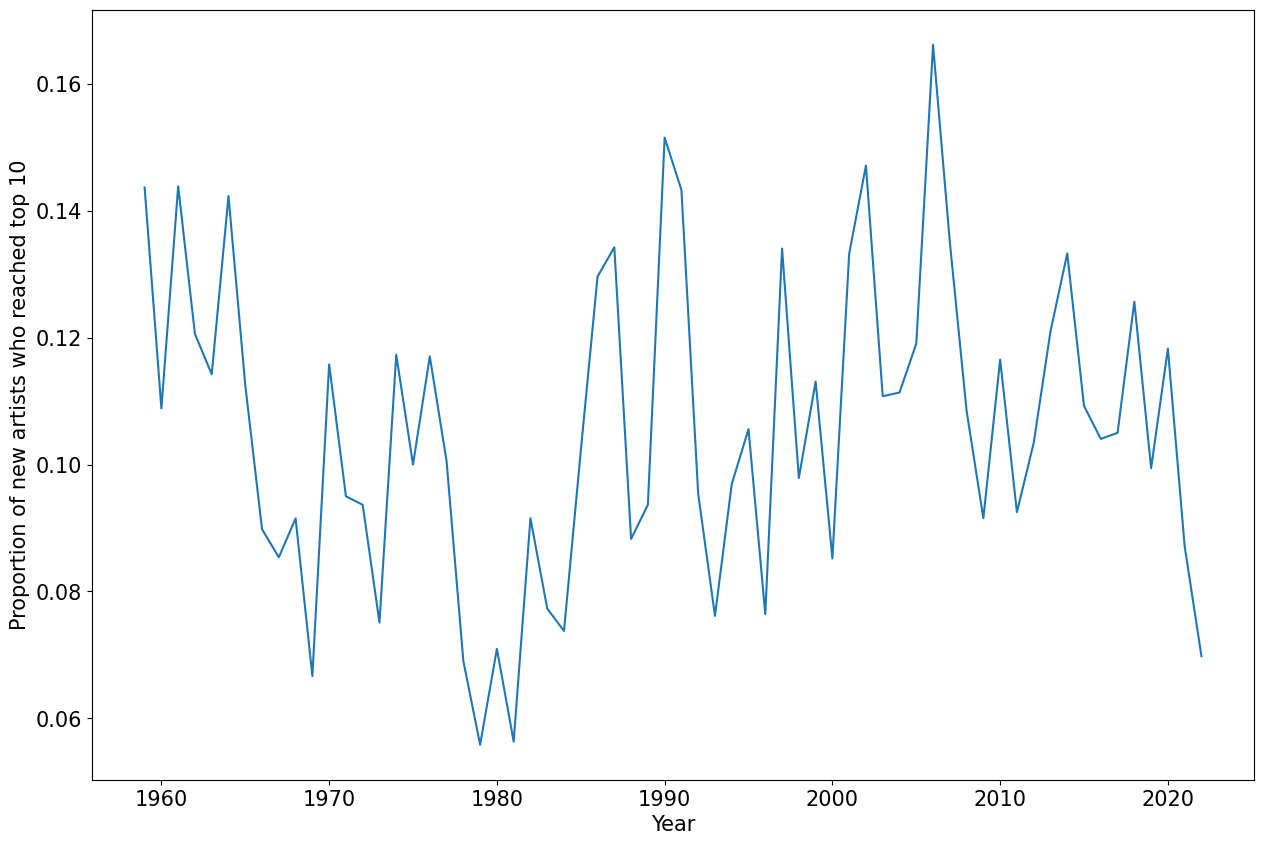

In [65]:
plt.figure(figsize=(15, 10))

percentages = []
for year in range(1959, 2023):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist", "top_position"]]
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year]["artist"]
    new_artists = artists_from_year[~artists_from_year["artist"].isin(artists_from_previous_years)]
    new_artists_top_10 = new_artists[new_artists["top_position"] <= 10]
    percentage_of_new_artists = len(new_artists_top_10)/len(artists_from_year)
    percentages.append(percentage_of_new_artists)

plt.plot(range(1959, 2023), percentages)

plt.xlabel("Year")
plt.ylabel("Proportion of new artists who reached top 10")
plt.savefig("figures/proportion_of_new_artists_top_10_yearly.pdf", format="pdf")
plt.show()

## How many artists reached top 10, who have never reached top 10 before

In [ ]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, 'valid')

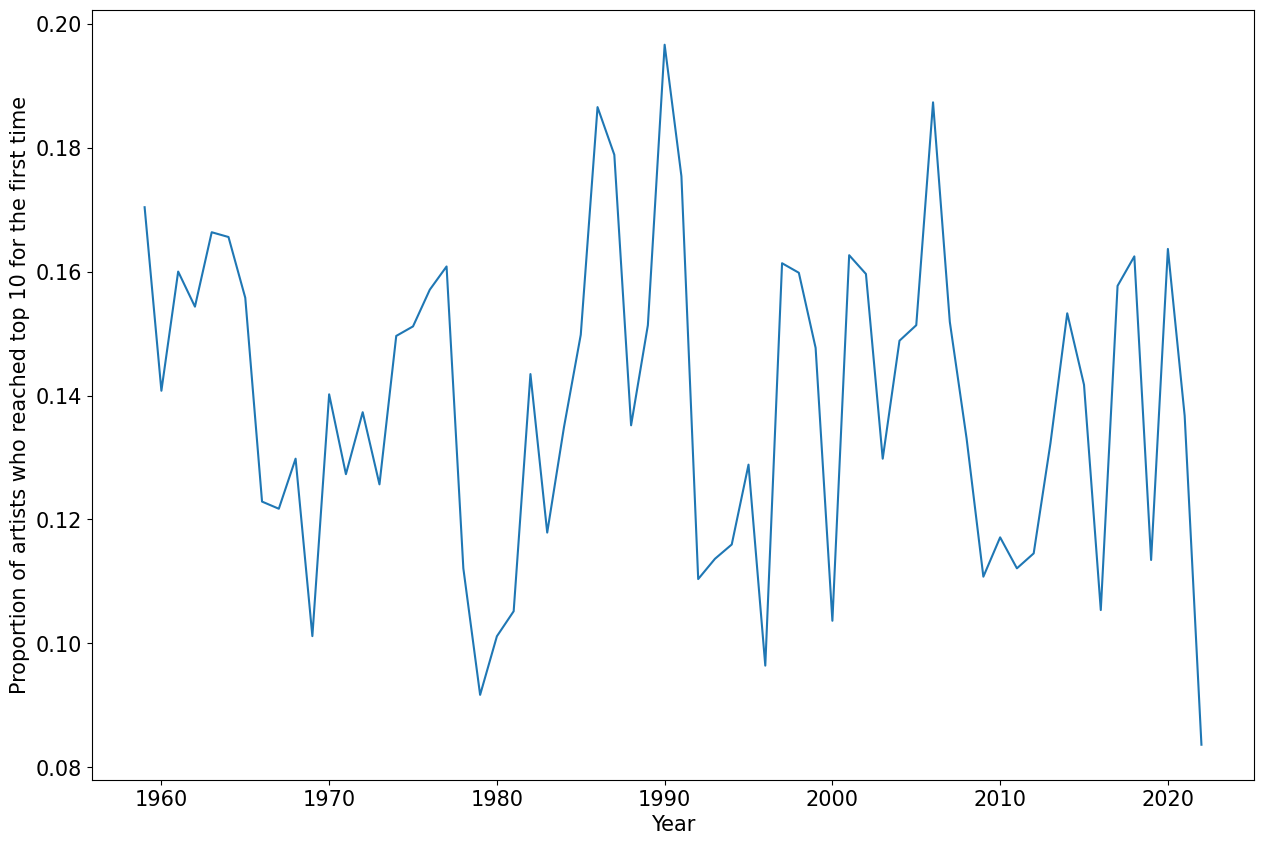

In [66]:
plt.figure(figsize=(15, 10))

percentages = []
for year in range(1959, 2023):
    artists_from_year = billboard_hot_100[billboard_hot_100["year"] == year][["artist", "top_position"]]
    artists_from_previous_years = billboard_hot_100[billboard_hot_100["year"] < year][["artist", "top_position"]]
    artists_from_previous_years_top_10 = artists_from_previous_years[artists_from_previous_years["top_position"] <= 10]
    artists_from_this_year_top_10 = artists_from_year[artists_from_year["top_position"] <= 10]
    artists_top_10_never_in_top_10_before = artists_from_this_year_top_10[~artists_from_this_year_top_10["artist"].isin(artists_from_previous_years_top_10["artist"])]
    percentage_of_artists = len(artists_top_10_never_in_top_10_before)/len(artists_from_year)
    percentages.append(percentage_of_artists)

plt.plot(range(1959, 2023), percentages)

plt.xlabel("Year")
plt.ylabel("Proportion of artists who reached top 10 for the first time")
plt.savefig("figures/proportion_of_artists_in_top_10_first_time_yearly.pdf", format="pdf")
plt.show()